In [ ]:
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(33)

In [ ]:
from keras.datasets import mnist, fashion_mnist, cifar10

(train_x, train_labels), (test_x, test_labels) = mnist.load_data()

In [ ]:
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1] * train_x.shape[2])
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1] * test_x.shape[2])

train_x = train_x.astype(np.float32)
test_x = test_x.astype(np.float32)

train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)

NameError: ignored

In [ ]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

Передаточные функции

In [ ]:
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1, keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
    
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p

class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

class Sigmoid:
    def forward(self, x):
      y = 1 / (1 + np.exp(-x))
      self.y = y
      return y

    def backward(self, dy):
      return dy* self.y * (1 - self.y)

class Relu:
    def forward(self, x):
      y = np.maximum(0, x)
      self.y = y
      return y
    
    def backward(self, dy):
      return np.multiply(dy, np.int64(self.y > 0))

In [ ]:
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
  fig.suptitle('History')
  
  ax1.plot(history['train_accuracy'], 'o-', label='train')
  ax1.plot(history['val_accuracy'], 'o-', label='test')
  ax1.legend(loc="upper right")
  ax1.set_ylabel('Accuracy')

  ax2.plot(history['train_loss'], 'o-', label='train')
  ax2.plot(history['val_loss'], 'o-', label='test')
  ax2.legend(loc="upper right")
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('Loss')

  plt.show()

In [ ]:
def calc_conf_mat(x, y, labels):
  p = net.forward(x)
  pred = np.argmax(p, axis=1)
  return confusion_matrix(y, pred, labels=labels)

def plot_matrix(conf_matrix):
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix)
  
def get_loss_acc(x, y, loss=CrossEntropyLoss()):
    p = net.forward(x)
    l = loss.forward(p,y)
    pred = np.argmax(p, axis=1)
    acc = (pred==y).mean()
    return l, acc

def train_epoch(net, train_x, train_labels, loss=CrossEntropyLoss(), batch_size=128, lr=0.2):
    for i in tqdm(range(0,len(train_x),batch_size)):
        xb = train_x[i:i+batch_size]
        yb = train_labels[i:i+batch_size]

        p = net.forward(xb)
        l = loss.forward(p,yb)
        dp = loss.backward(l)
        dx = net.backward(dp)
        net.update(lr)

In [ ]:
net = Net()
net.add(Linear(784, 256))
net.add(Tanh())
net.add(Linear(256, 10))
net.add(Softmax())
loss = CrossEntropyLoss()

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))
history = pd.DataFrame(columns=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])

for i in range(10):
  train_epoch(net,train_x,train_labels, batch_size=2048, lr=0.2)

  mean_loss, mean_acc = get_loss_acc(train_x, train_labels)
  mean_loss_val, mean_acc_val = get_loss_acc(test_x, test_labels)

  history = history.append(pd.Series(
          data=[mean_loss, mean_loss_val, mean_acc, mean_acc_val], 
          index=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']),
          ignore_index=True) 
  
  print(f'Train loss - {mean_loss}, accuracy - {mean_acc}\n Test loss {mean_loss_val}, accuracy - {mean_acc_val}')

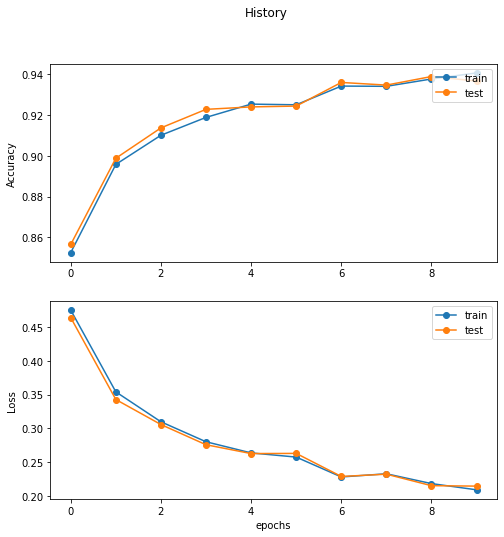

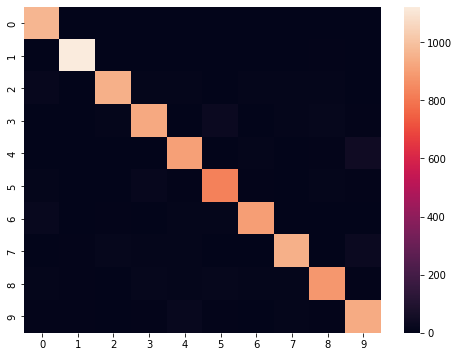

In [ ]:
plot_history(history)
plot_matrix(calc_conf_mat(test_x, test_labels, [i for i in range(10)]))

In [ ]:
net = Net()
net.add(Linear(784, 256))
net.add(Tanh())
net.add(Linear(256, 128))
net.add(Relu())
net.add(Linear(128, 10))
net.add(Softmax())
loss = CrossEntropyLoss()

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))
history = pd.DataFrame(columns=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])

for i in range(10):
  train_epoch(net,train_x,train_labels, batch_size=2048, lr=0.2)

  mean_loss, mean_acc = get_loss_acc(train_x, train_labels)
  mean_loss_val, mean_acc_val = get_loss_acc(test_x, test_labels)

  history = history.append(pd.Series(
          data=[mean_loss, mean_loss_val, mean_acc, mean_acc_val], 
          index=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']),
          ignore_index=True) 
  
  print(f'Train loss - {mean_loss}, accuracy - {mean_acc}\n Test loss {mean_loss_val}, accuracy - {mean_acc_val}')

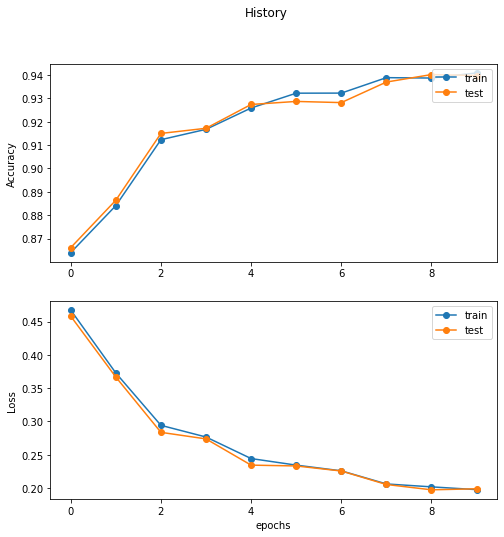

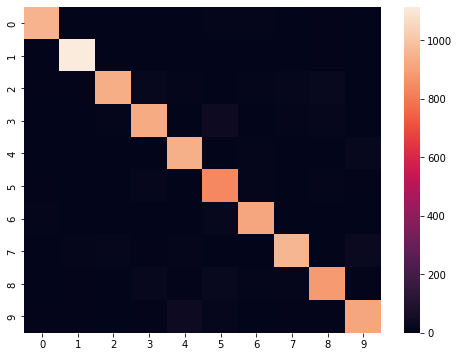

In [ ]:
plot_history(history)
plot_matrix(calc_conf_mat(test_x, test_labels, [i for i in range(10)]))

In [ ]:
net = Net()
net.add(Linear(784, 128))
net.add(Tanh())
net.add(Linear(128, 128))
net.add(Relu())
net.add(Linear(128, 10))
net.add(Softmax())
loss = CrossEntropyLoss()

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))
history = pd.DataFrame(columns=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])

for i in range(10):
  train_epoch(net,train_x,train_labels, batch_size=2048, lr=0.2)

  mean_loss, mean_acc = get_loss_acc(train_x, train_labels)
  mean_loss_val, mean_acc_val = get_loss_acc(test_x, test_labels)

  history = history.append(pd.Series(
          data=[mean_loss, mean_loss_val, mean_acc, mean_acc_val], 
          index=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']),
          ignore_index=True) 
  
  print(f'Train loss - {mean_loss}, accuracy - {mean_acc}\n Test loss {mean_loss_val}, accuracy - {mean_acc_val}')

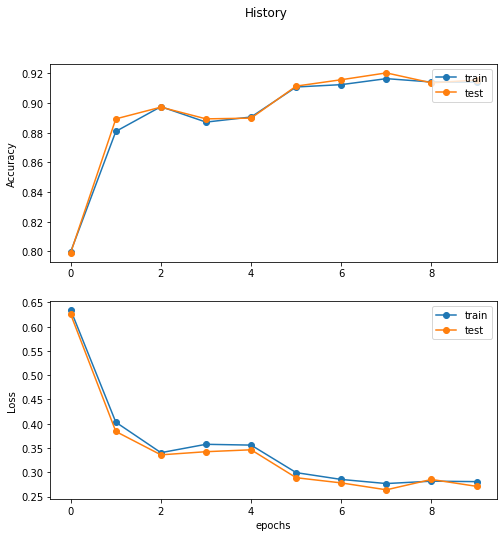

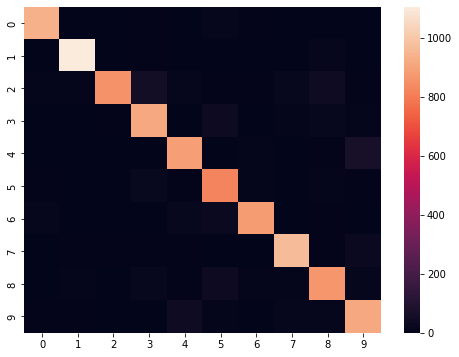

In [ ]:
plot_history(history)
plot_matrix(calc_conf_mat(test_x, test_labels, [i for i in range(10)]))

#Fashion Mnist


In [ ]:
(train_x, train_labels), (test_x, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1] * train_x.shape[2])
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1] * test_x.shape[2])

train_x = train_x.astype(np.float32)
test_x = test_x.astype(np.float32)

train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)

In [ ]:
net = Net()
net.add(Linear(784, 256))
net.add(Tanh())
net.add(Linear(256, 10))
net.add(Softmax())
loss = CrossEntropyLoss()

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))
history = pd.DataFrame(columns=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])

for i in range(10):
  train_epoch(net,train_x,train_labels, batch_size=2048, lr=0.05)

  mean_loss, mean_acc = get_loss_acc(train_x, train_labels)
  mean_loss_val, mean_acc_val = get_loss_acc(test_x, test_labels)

  history = history.append(pd.Series(
          data=[mean_loss, mean_loss_val, mean_acc, mean_acc_val], 
          index=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']),
          ignore_index=True) 
  
  print(f'Train loss - {mean_loss}, accuracy - {mean_acc}\n Test loss {mean_loss_val}, accuracy - {mean_acc_val}')

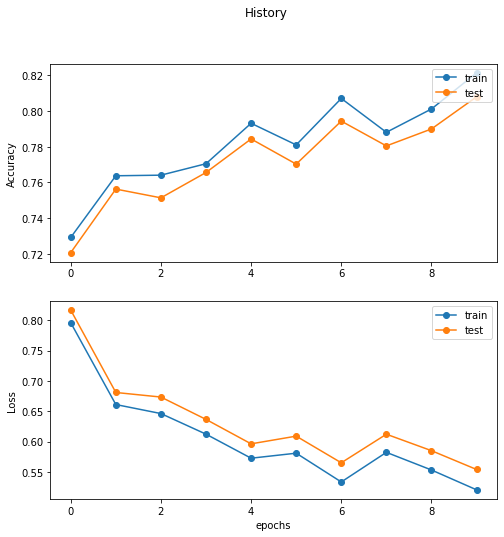

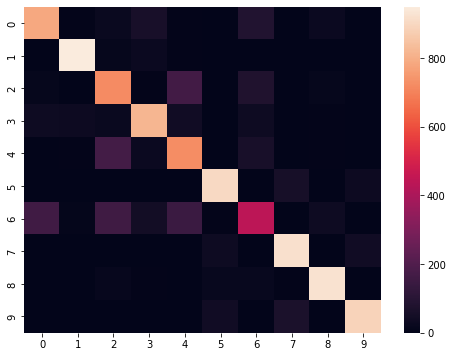

In [ ]:
plot_history(history)
plot_matrix(calc_conf_mat(test_x, test_labels, [i for i in range(10)]))

In [ ]:
net = Net()
net.add(Linear(784, 256))
net.add(Tanh())
net.add(Linear(256, 128))
net.add(Relu())
net.add(Linear(128, 10))
net.add(Softmax())
loss = CrossEntropyLoss()

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))
history = pd.DataFrame(columns=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])

for i in range(10):
  train_epoch(net,train_x,train_labels, batch_size=2048, lr=0.05)

  mean_loss, mean_acc = get_loss_acc(train_x, train_labels)
  mean_loss_val, mean_acc_val = get_loss_acc(test_x, test_labels)

  history = history.append(pd.Series(
          data=[mean_loss, mean_loss_val, mean_acc, mean_acc_val], 
          index=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']),
          ignore_index=True) 
  
  print(f'Train loss - {mean_loss}, accuracy - {mean_acc}\n Test loss {mean_loss_val}, accuracy - {mean_acc_val}')

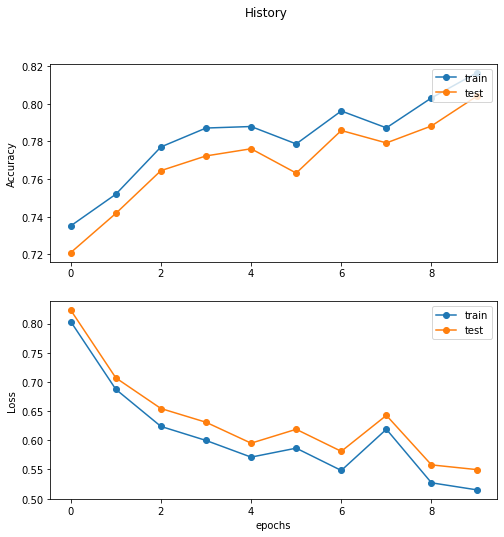

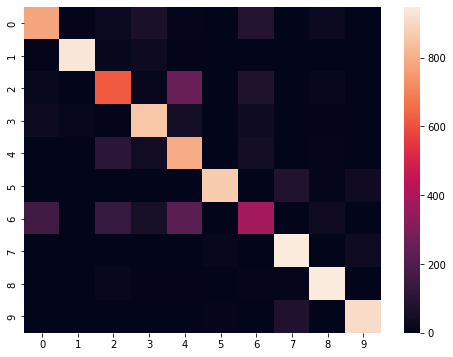

In [ ]:
plot_history(history)
plot_matrix(calc_conf_mat(test_x, test_labels, [i for i in range(10)]))

In [ ]:
net = Net()
net.add(Linear(784, 1024))
net.add(Tanh())
net.add(Linear(1024, 512)) 
net.add(Relu())
net.add(Linear(512, 256))
net.add(Relu())
net.add(Linear(256, 10))
net.add(Softmax())
loss = CrossEntropyLoss()

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))
history = pd.DataFrame(columns=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])

for i in range(25):
  train_epoch(net,train_x,train_labels, batch_size=2048, lr=0.05)

  mean_loss, mean_acc = get_loss_acc(train_x, train_labels)
  mean_loss_val, mean_acc_val = get_loss_acc(test_x, test_labels)

  history = history.append(pd.Series(
          data=[mean_loss, mean_loss_val, mean_acc, mean_acc_val], 
          index=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']),
          ignore_index=True) 
  
  print(f'Train loss - {mean_loss}, accuracy - {mean_acc}\n Test loss {mean_loss_val}, accuracy - {mean_acc_val}')

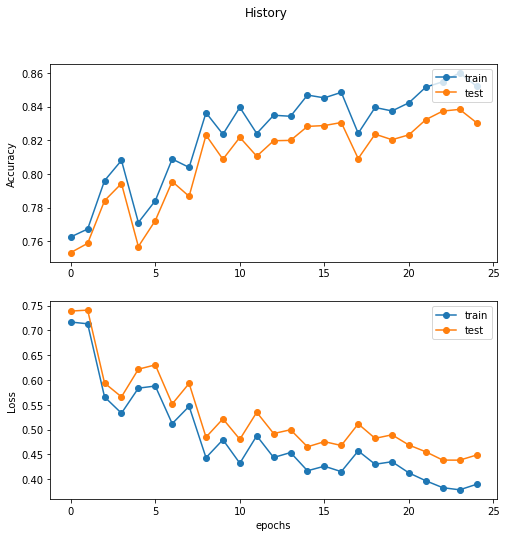

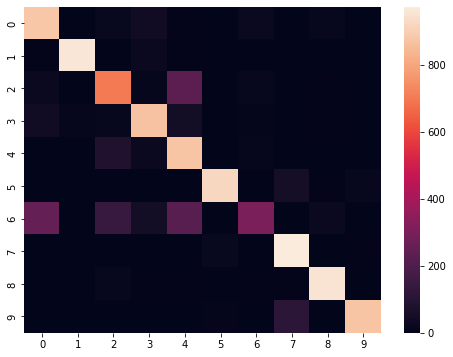

In [ ]:
plot_history(history)
plot_matrix(calc_conf_mat(test_x, test_labels, [i for i in range(10)]))

#cifar10

In [ ]:
(train_x, train_labels), (test_x, test_labels) = cifar10.load_data()

In [ ]:
train_x.shape

(50000, 32, 32, 3)

In [ ]:
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1] * train_x.shape[2] * train_x.shape[3])
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1] * test_x.shape[2] * test_x.shape[3])

train_x = train_x.astype(np.float32)
test_x = test_x.astype(np.float32)

train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)

In [ ]:
test_x.shape

(10000, 3072)

In [ ]:
def get_loss_acc(x, y, batch_size=10000, loss=CrossEntropyLoss()):
  accuracy, ls = [], []
  for i in range(0, len(x), batch_size):
    xb = train_x[i:i+batch_size]
    yb = train_labels[i:i+batch_size]

    p = net.forward(xb)
    l = loss.forward(p,yb)
    pred = np.argmax(p, axis=1)
    acc = (pred==y).mean()

    ls.append(l)
    accuracy.append(acc)

  return np.mean(ls[np.isfinite(ls)]), np.mean(accuracy)

In [ ]:
net = Net()
net.add(Linear(3072, 10))
net.add(Softmax())

loss = CrossEntropyLoss()

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(train_x, train_labels)))

In [ ]:
net = Net()
net.add(Linear(3072, 10))
net.add(Softmax())

loss = CrossEntropyLoss()

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(train_x, train_labels)))
history = pd.DataFrame(columns=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])

for i in range(10):
  train_epoch(net,train_x,train_labels, batch_size=256, lr=0.05)

  mean_loss, mean_acc = get_loss_acc(train_x, train_labels)
  mean_loss_val, mean_acc_val = get_loss_acc(test_x, test_labels)

  history = history.append(pd.Series(
          data=[mean_loss, mean_loss_val, mean_acc, mean_acc_val], 
          index=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']),
          ignore_index=True) 
  
  print(f'Train loss - {mean_loss}, accuracy - {mean_acc}\n Test loss {mean_loss_val}, accuracy - {mean_acc_val}')

In [ ]:
plot_history(history)
plot_matrix(calc_conf_mat(test_x, test_labels, [i for i in range(10)]))

In [ ]:
net = Net()
net.add(Linear(3072, 512))
net.add(Tanh())
net.add(Linear(512, 10)) 
net.add(Softmax())

loss = CrossEntropyLoss()

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))
history = pd.DataFrame(columns=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])

for i in range(15):
  train_epoch(net,train_x,train_labels, batch_size=2048, lr=0.05)

  mean_loss, mean_acc = get_loss_acc(train_x, train_labels)
  mean_loss_val, mean_acc_val = get_loss_acc(test_x, test_labels)

  history = history.append(pd.Series(
          data=[mean_loss, mean_loss_val, mean_acc, mean_acc_val], 
          index=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']),
          ignore_index=True) 
  
  print(f'Train loss - {mean_loss}, accuracy - {mean_acc}\n Test loss {mean_loss_val}, accuracy - {mean_acc_val}')

In [ ]:
plot_history(history)
plot_matrix(calc_conf_mat(test_x, test_labels, [i for i in range(10)]))

In [ ]:
net = Net()
net.add(Linear(3072, 2048))
net.add(Relu())
net.add(Linear(2048, 512)) 
net.add(Relu())
net.add(Linear(512, 256))
net.add(Relu())
net.add(Linear(256, 128))
net.add(Relu())
net.add(Linear(128, 10)) 
net.add(Softmax())

loss = CrossEntropyLoss()

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(train_x,train_labels)))
history = pd.DataFrame(columns=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])

for i in range(15):
  train_epoch(net,train_x,train_labels, batch_size=2048, lr=0.05)

  mean_loss, mean_acc = get_loss_acc(train_x, train_labels)
  mean_loss_val, mean_acc_val = get_loss_acc(test_x, test_labels)

  history = history.append(pd.Series(
          data=[mean_loss, mean_loss_val, mean_acc, mean_acc_val], 
          index=['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']),
          ignore_index=True) 
  
  print(f'Train loss - {mean_loss}, accuracy - {mean_acc}\n Test loss {mean_loss_val}, accuracy - {mean_acc_val}')

In [ ]:
plot_history(history)
plot_matrix(calc_conf_mat(test_x, test_labels, [i for i in range(10)]))